In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("../../thesis-style.mpl")

In [3]:
import thesis

In [4]:
import numpy as np

In [5]:
import elk.catalogue

/home/daniel/repositories/elk/elk/__init__.py:4: UserWarning: Module thesis was already imported from thesis.pyc, but /home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/thesis-0.0.1-py2.7.egg is being added to sys.path
  from pkg_resources import resource_string
/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/h5py-2.7.0-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
catalogue = elk.catalogue.NRCatalogue(origin="GeorgiaTech")

In [7]:
query_table = catalogue.table.query( "spin_1x == 0 & spin_1y == 0 & spin_1z == 0"
            " & spin_2x == 0 & spin_2y == 0 & spin_2z == 0")

In [8]:
query_waveforms = [waveform for waveform in catalogue.waveforms if waveform.tag in list(query_table['tag'])]

In [9]:
import heron
from heron import waveform
from george import kernels

In [10]:
total_mass = 60

In [11]:
problem_dims = 8
c_ind = catalogue.c_ind
time_covariance = kernels.RationalQuadraticKernel(.05, 400,
                                           ndim=problem_dims,
                                           axes=c_ind['time'],)
#time_covariance = kernels.ExpSquaredKernel([50], ndim=problem_dims, axes=c_ind['time'])
mass_covariance = kernels.ExpSquaredKernel(0.005, #0.09
#mass_covariance = kernels.Matern52Kernel(0.005, #0.09
                                           ndim=problem_dims,
                                           axes=c_ind['mass ratio'])
#spin_covariance = kernels.ExpSquaredKernel([0.005, 0.005, 0.005, 
spin_covariance = kernels.Matern52Kernel([0.005, 0.005, 0.005, 
                                            0.005, 0.005, 0.005], 
                                           ndim=problem_dims, 
                                           axes=[2,3,4,5,6,7])

covariance =  1e1 * time_covariance * mass_covariance * spin_covariance

gp = gp_cat = waveform.GPCatalogue(catalogue, covariance,
                                   total_mass=total_mass, fsample=2048,
                                   mean=0.0,
                                   ma=[(2,2), (2,-2), (2,0), (2,1), (2,-1)],
                                   solver="hodlr",
                                   white_noise=1e-6,
                                   fmin=95,)

There was an error producing a waveform for GT0392


In [15]:
def sample_plot(gp_cat, p, surrogates=True, phase_shift=(0,0), nsamples=100):
    """
    Make a plot to compare sample draws from the GPR to SEOBNRv4 and 
    IMRPhenomPv2.
    """
    samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-150, 100, 1024], samples=nsamples)
    
    if surrogates:
        imr = imr_cat.waveform(p=p,
                            time_range=[-150., 100., 1024],
                              coa_phase=phase_shift[0],
                              )
        #imr[0].times -= imr[0].times[np.argmax(imr[0].data)]
        seo = seo_cat.waveform(p=p,
                        time_range=[-150., 100., 1024],
                              coa_phase=phase_shift[1],)
        #seo[0].times -= seo[0].times[np.argmax(seo[0].data)]
    width = 4.5
    height = width/1.618
    f, ax = plt.subplots(1,1, figsize=(2*width, height), dpi=300);
    mean, var = gp_cat.waveform(p=p, time_range= [-150, 100, 1024])
    times = np.linspace(-.0150,.0100, 1024)
    #times -= times[np.argmax(mean)]
    waveforms = []
    for sample in samples:
        #sample.times -= sample.times[np.argmax(mean)]
        ax.plot(sample.times/1e4, sample.data/1e19, alpha=0.05, color='k');
        waveforms.append(sample.data)

    #mean = np.array(waveforms).mean(axis=0)
    
    ax.plot(times, mean, color="#7e25aa", label="GPR Mean")
        
    if surrogates:
        ax.plot(imr[0].times, imr[0].data, label="IMRPhenomPv2");
        ax.plot(seo[0].times, seo[0].data, label="SEOBNRv4");
        
    ax.set_xlabel("Times [sec] from merger");
    ax.set_ylabel("Strain (h+)");

    f = thesis.thesisify(f)
     
    #ax.plot(imr[0].times*1e4, 1024*mean/1e16, color="#7e25aa", label="GPR Mean")
    
    ax.legend(prop=ssp_legend);
    
    return f, ax

In [13]:
gp_cat.gp.set_parameter_vector(np.log([10,
                                       200, 500, 
                                       .000525,
                                       0.000005, 0.000005, 0.000005,
                                       0.000005, 0.000005, 0.000005,]))
gp_cat.gp.white_noise.value=1e-5

AttributeError: 'module' object has no attribute 'thesisify'

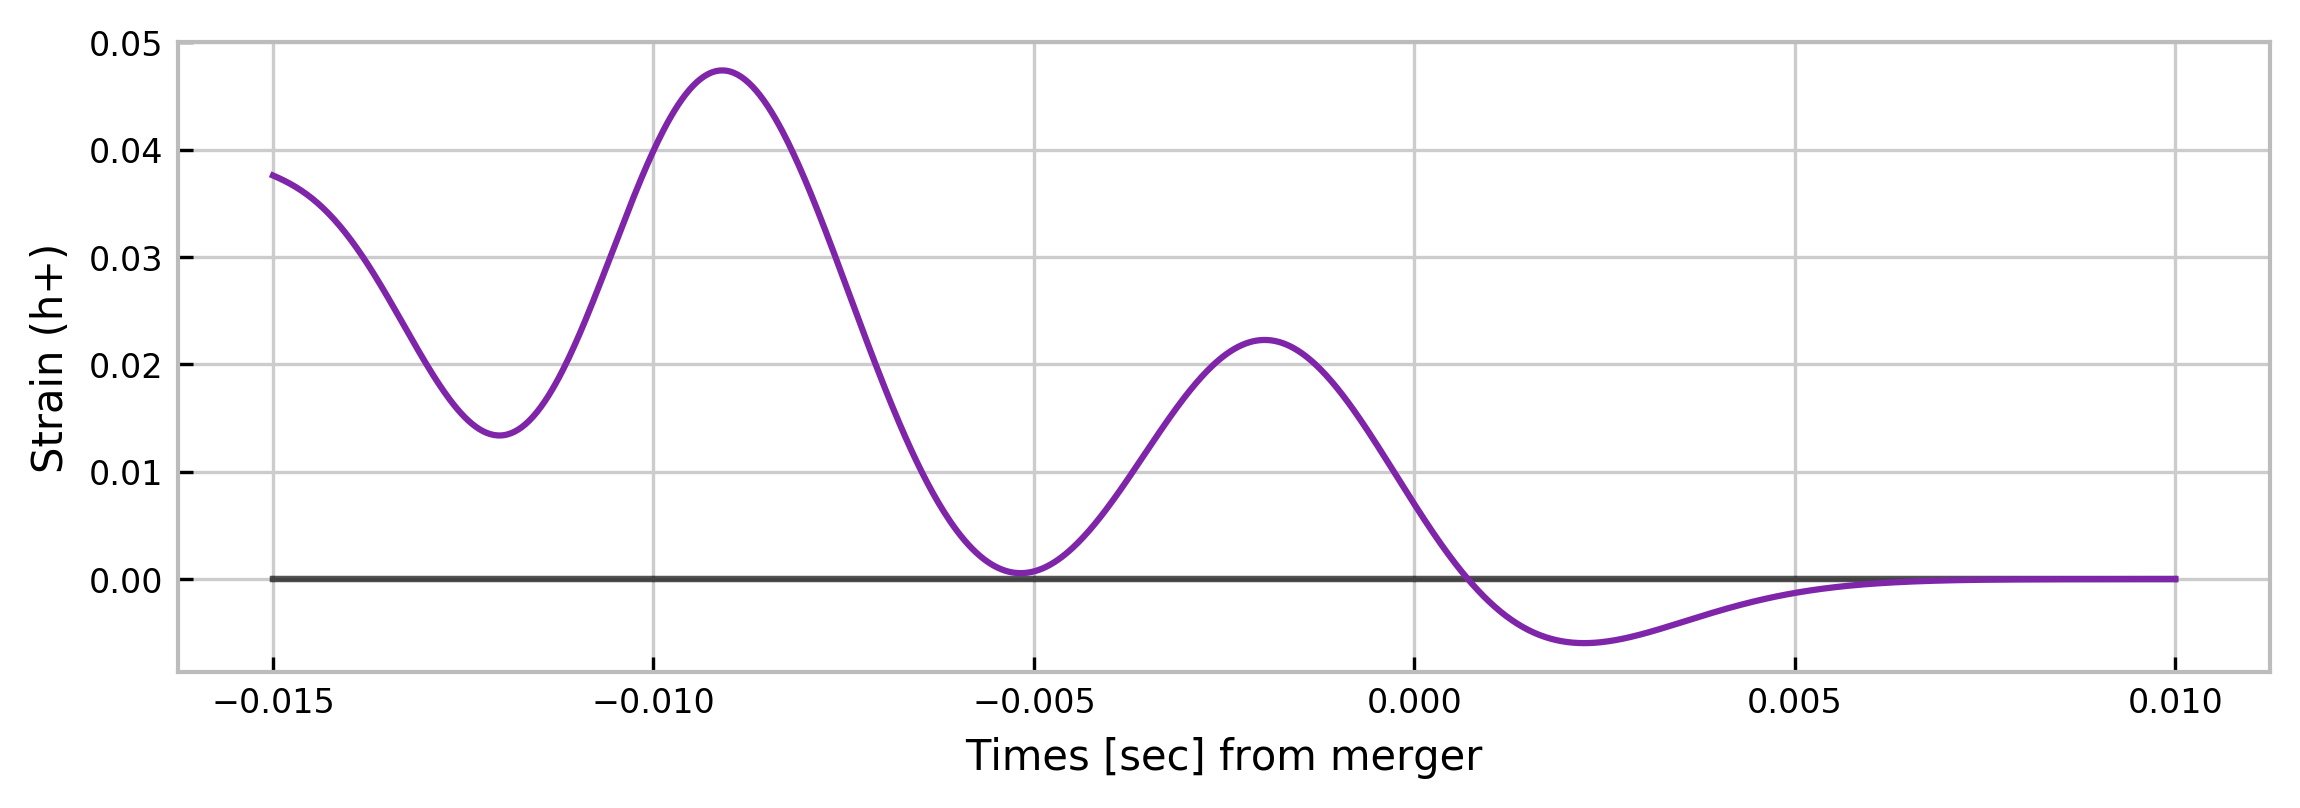

In [16]:
for waveform in query_waveforms[0:1]:


    f, ax = sample_plot(gp_cat, {"mass ratio": waveform.mass_ratio, #waveform.mass_ratio,
                     "spin 1x": waveform.spin_1x, "spin 1y": waveform.spin_1y, "spin 1z": waveform.spin_1z,
                     "spin 2x": waveform.spin_2x, "spin 2y": waveform.spin_2y, "spin 2z": waveform.spin_2z,},
                        phase_shift = (1.94, 1.94), #(1.04, 1.04), #(2.86, 1.84,)
                        surrogates=False,
                        nsamples=20,
               );

    #- plt.title("{} - q={}".format(waveform.tag, waveform.mass_ratio))
    ts = waveform.timeseries(60, flow=60, )[0] # ma=((2,2))
    #ts.times -= ts.times[np.argmax(ts.data)]
    ax.plot(ts.times, ts.data, label="NR Waveform", color="pink")
    ax.set_xlim([-.0150, .0100])
    ax.legend(prop=ssp_legend)
#f.savefig("withnr.pdf".format(waveform.tag))

In [ ]:
query_waveforms[:3]

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u"'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


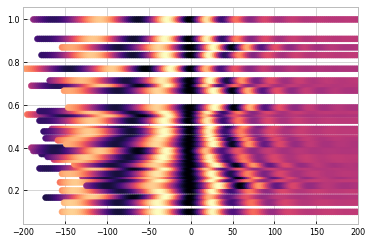

In [9]:
X = []
Y = []
for waveform in query_waveforms:
    ts = waveform.timeseries(60, flow=95, sample_rate=4096, coa_phase=1./waveform.mass_ratio)[0]
    
    ix = np.argmax((ts.data))
    ts.times -= ts.times[ix]
    
    x = np.array([waveform.mass_ratio])
    y = np.array(ts.data[[ix, 20+ix,50+ix,100-ix]])
    
    X.append(x)
    Y.append(y)
    plt.scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), c = ts.data)
    
    plt.xlim([-200, 200])

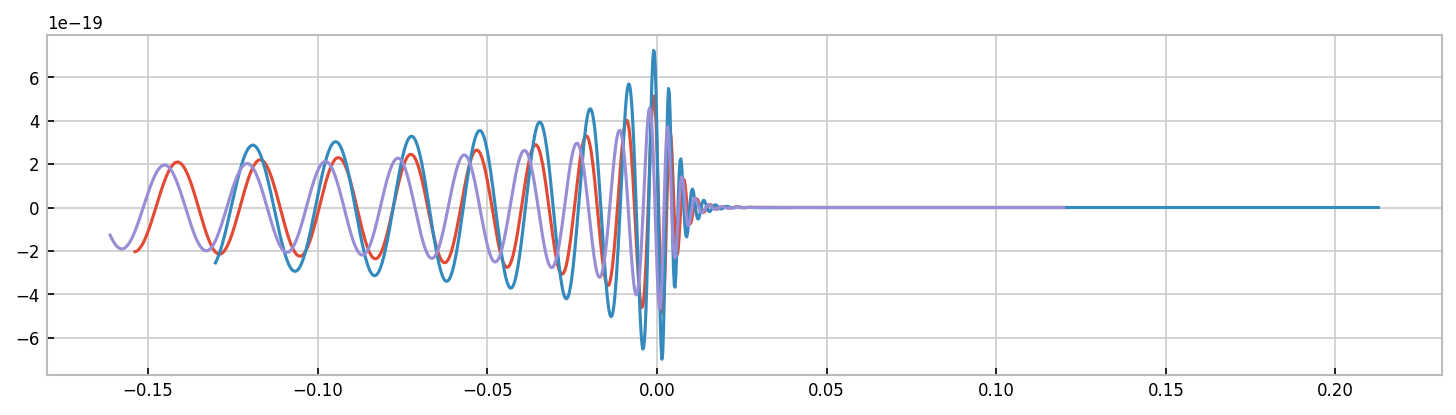

In [20]:
plt.figure(figsize=(12,3), dpi=150)
phases = [4.5, 0, 0]
for waveform, phase in zip(query_waveforms[:3], phases):
    ts = waveform.timeseries(60, flow=40, f_ref=1000, sample_rate=4096, coa_phase=phase)[0]
    
    ix = np.argmax((ts.data))
   # ts.times -= ts.times[ix]
    
    plt.plot(ts.times, ts.data)

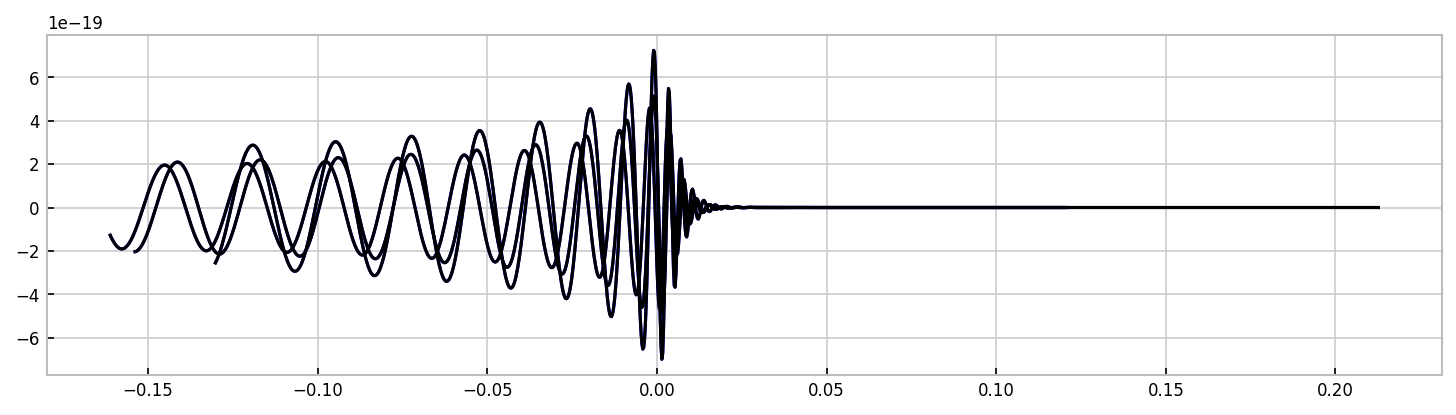

In [24]:
plt.figure(figsize=(12,3), dpi=150)
phases = [4.5, 0, 0]
for waveform, phase in zip(query_waveforms[:3], phases):
    ts = waveform.timeseries(60, flow=40, f_ref=50, sample_rate=4096, coa_phase=phase)[0]
    
    ix = np.argmax((ts.data))
   # ts.times -= ts.times[ix]
    
    plt.plot(ts.times, ts.data, color='b')
    
for waveform, phase in zip(query_waveforms[:3], phases):
    ts = waveform.timeseries(60, flow=40, f_ref=2000, sample_rate=4096, coa_phase=phase)[0]
    
    ix = np.argmax((ts.data))
   # ts.times -= ts.times[ix]
    
    plt.plot(ts.times, ts.data, color='k')

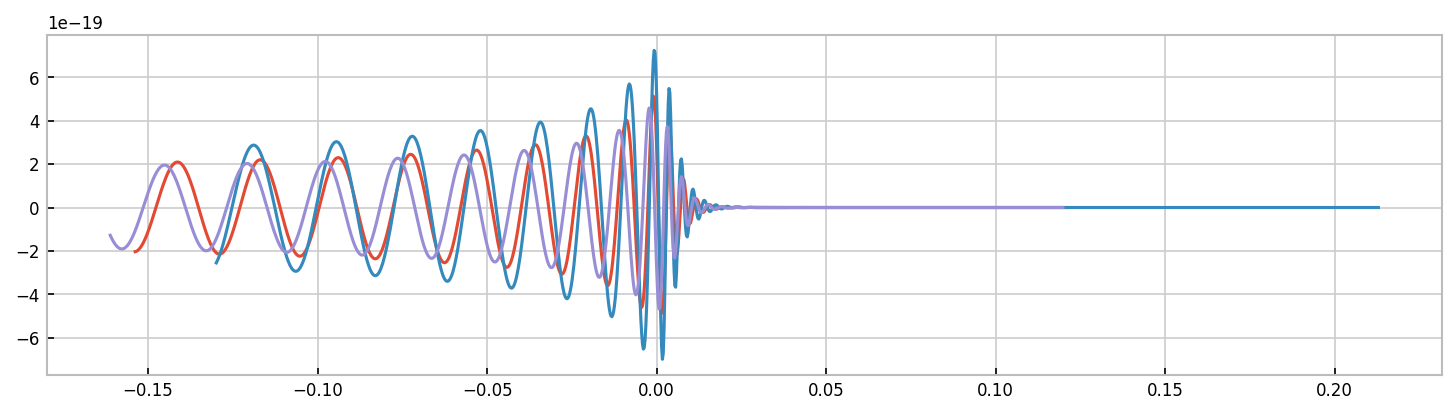

In [19]:
plt.figure(figsize=(12,3), dpi=150)
phases = [4.5, 0, 0]
for waveform, phase in zip(query_waveforms[:3], phases):
    ts = waveform.timeseries(60, flow=40, f_ref=40, sample_rate=4096, coa_phase=phase, ma=[(2,2)])[0]
    
    ix = np.argmax((ts.data))
    #ts.times -= ts.times[ix]
    
    plt.plot(ts.times, ts.data)

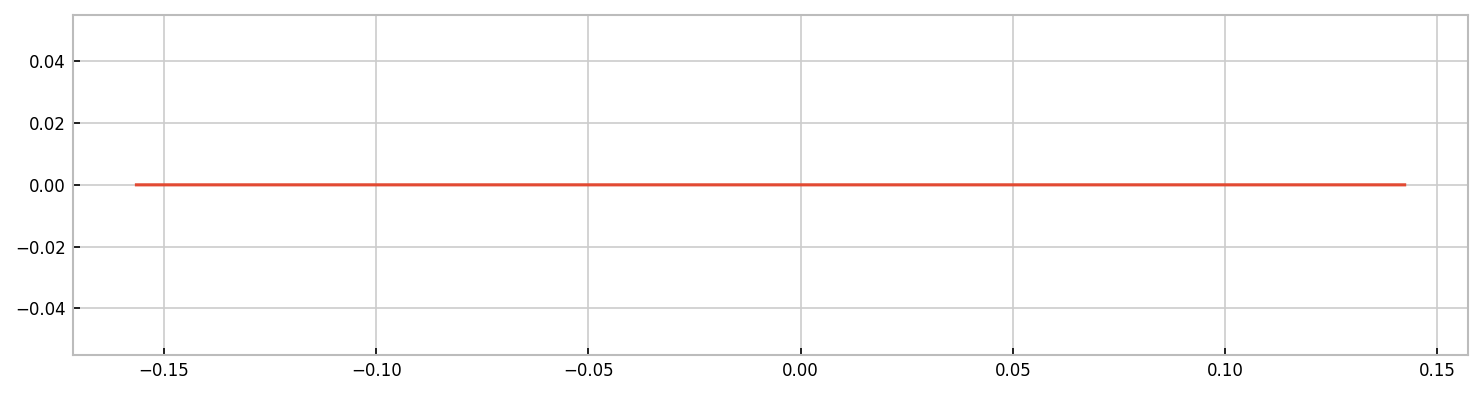

In [50]:
plt.figure(figsize=(12,3), dpi=150)
phases = [4.5, 0, 0]
waveform = catalogue.waveforms[15]

tsa = waveform.timeseries(60, flow=40, f_ref=ref, sample_rate=4096, coa_phase=phase, ma=[(2,2), (2,1), (2,0), (2,-1), (2,-2)])[0]
ix = np.argmax((ts.data))
#ts.times -= ts.times[ix]
#plt.plot(tsa.times, tsa.data)

tsb = waveform.timeseries(60, flow=40, f_ref=ref, sample_rate=4096, coa_phase=phase, ma=[(2,2)])[0]
ix = np.argmax((ts.data))
#ts.times -= ts.times[ix]
plt.plot(tsb.times, tsa.data - tsb.data)

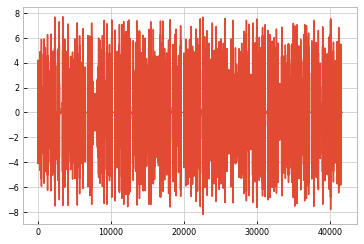

In [17]:
plt.plot(gp.training_data[:,-2])

In [27]:
X = np.atleast_2d(np.hstack(X))
#Y = np.hstack(Y)*1e19

In [28]:
Y = np.vstack(Y)

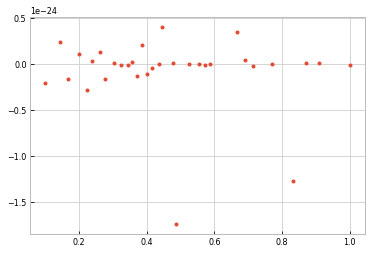

In [29]:
#plt.plot(X[0, :],Y[:,0], '.')
#plt.plot(X[0, :],Y[:,1], '.')
plt.plot(X[0, :],Y[:,2], '.')

In [21]:
import pymc3 as pm

In [22]:
#X = x[(0),:5000][::,None]#.T
#Y = y[:5000]

with pm.Model() as model:
    
    amp_t = pm.Uniform("amplitude_time", 1, 15)
    #amp_q = pm.Uniform("amplitude_q", 1, 15)
    #ls_t =  pm.Uniform("time", 0, .1) #pm.Gamma("metric_time", alpha=3, beta=0.5)
    ls_q = pm.Uniform("metric_q", 0,.1)#pm.Gamma("metric_q", alpha=3, beta=0.5)
    #ls_L = pm.Uniform("metric_L", 0,1, shape=3)
    # Specify the covariance function.
    
    cov_func = pm.gp.cov.ExpQuad(2, active_dims=[0], ls=.1) #* pm.gp.cov.ExpQuad(3, active_dims=(8,9,10), ls=ls_L)

    
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    s = pm.Normal("sigma", .00125, 0.1)
    y_ = gp.marginal_likelihood("y", X=np.atleast_2d(X[0,:]).T, y=Y[:,0], noise=0.001, is_observed=True)

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [23]:
q_new = np.linspace(0,1, 100)[::,None]
    #t_new = np.linspace(-0.02,0.1, 400)#[::,None]
    #x_new = np.dstack([t_new, q_new])
    #print(x_new[0])
    #mp['time'] = np.array(0.01)
    #mp['time_interval__'] = np.array(.001)
mu, var = gp.predict(q_new, diag=True)
sd = np.sqrt(var)
#plt.scatter(x = t_new, y= q_new, c = mu)

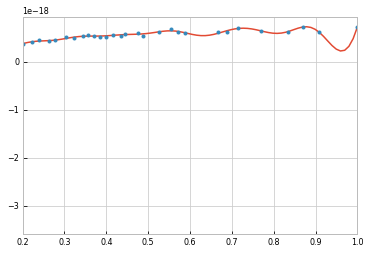

In [24]:
plt.plot(q_new, mu)
plt.xlim([0.2,1])
#plt.ylim([0,1e-18])
plt.plot(X[0, :],Y[:,0], '.')